In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV


In [92]:
costa_rica = pd.read_csv("clean_cr.csv")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
costa_rica
costa_rica = costa_rica.iloc[:, :-11]

In [93]:
# Split data into train, validation, and test sets with 70/10/20 split
train, test = train_test_split(costa_rica, test_size=0.3)
valid, test = train_test_split(test, test_size=0.1)
x_train = train.drop(columns = ["Id", "idhogar","Target"])
y_train = train["Target"]
x_test = test.drop(columns = ["Id", "idhogar","Target"])
y_test = test["Target"]
x_valid = valid.drop(columns = ["Id", "idhogar","Target"])
y_valid = valid["Target"]

In [94]:
# Use variance threshold to find most important features
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)
selected_features = sel.get_feature_names_out(x_train.columns)

In [95]:
# Drop unwanted features
costa_rica = costa_rica[selected_features]
costa_rica = costa_rica.drop(columns = ["Unnamed: 0.1", "Unnamed: 0"])
costa_rica.to_csv("good_data.csv")

In [96]:
# Impute missing values
imputer = KNNImputer()
x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=imputer.get_feature_names_out())
x_valid = pd.DataFrame(imputer.fit_transform(x_valid), columns=imputer.get_feature_names_out())

**K-Nearest Neighbors Classifier**

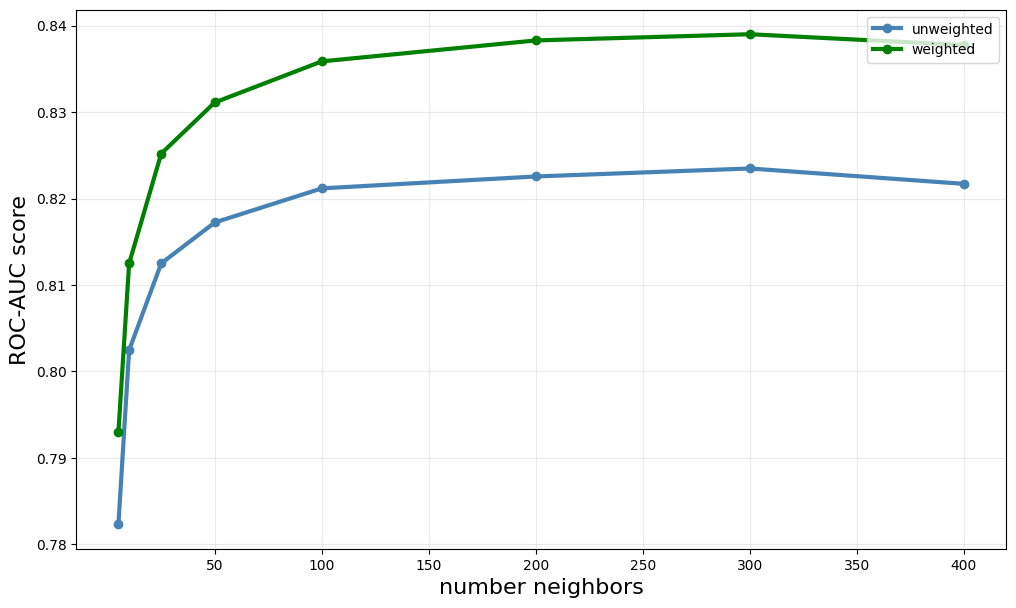

In [102]:
allks= [5,10,25,50,100,200,300, 400]
uw_scores = []
w_scores = []

# Unweighted
for k in allks:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    uw_scores.append(score)

# Weighted
for k in allks:
    knn = KNeighborsClassifier(n_neighbors = k, weights = "distance")
    knn.fit(x_train, y_train)
    y_pred = knn.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    w_scores.append(score)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(allks, uw_scores, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, w_scores, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("ROC-AUC score", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(50, 401, 50))
ax.grid(alpha=0.25)

**Decision Tree**

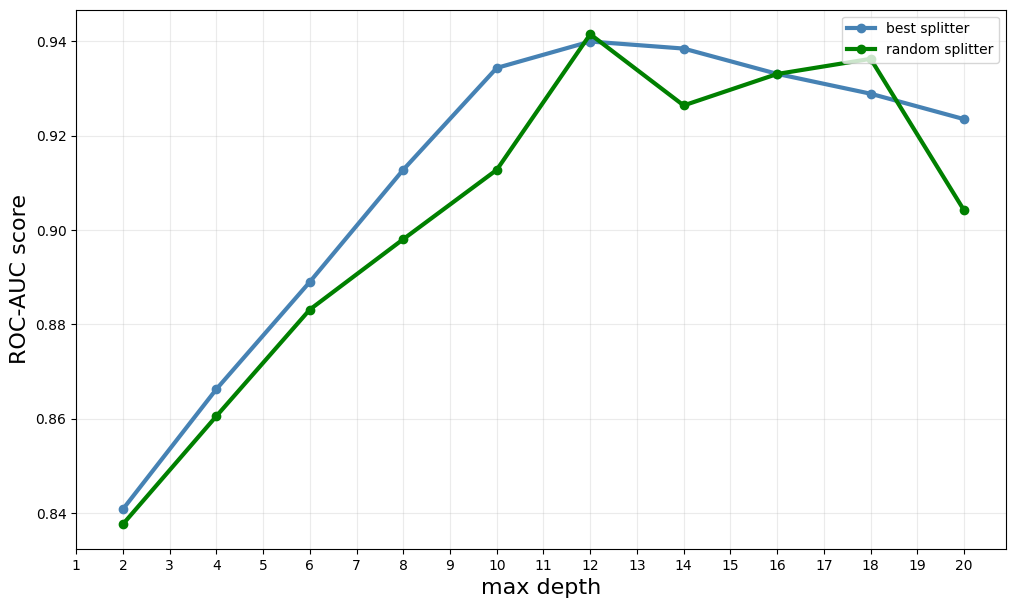

In [107]:
max_depths = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
best_score = []
random_score = []
trees = []

for d in max_depths:
    t = tree.DecisionTreeClassifier(splitter = "best", max_depth = d, random_state = 0)
    t.fit(x_train, y_train)
    y_pred = t.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    best_score.append(score)
    trees.append(t)

for d in max_depths:
    t = tree.DecisionTreeClassifier(splitter = "random", max_depth = d, random_state = 0)
    t.fit(x_train, y_train)
    y_pred = t.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    random_score.append(score)
    trees.append(t)
    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(max_depths, best_score, marker="o", color="steelblue", lw=3, label="best splitter")
ax.plot(max_depths, random_score, marker="o", color="green", lw=3, label="random splitter")
ax.set_xlabel("max depth", fontsize=16)
ax.set_ylabel("ROC-AUC score", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(1, 21, 1))
ax.grid(alpha=0.25)